In [1]:
import numpy as np
import torch
from torch import nn
from tropical import to_tensor, Tropical, TropicalMonomial, TropicalPolynomial, PolyNet, DiffPolyNet

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import JuPyMake
JuPyMake.InitializePolymake()
JuPyMake.ExecuteCommand("application 'tropical';")

(True, '', '', '')

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
def to_tensor(x):
    return torch.tensor(x).float()

# Создаем сеть 2-9-2 со случайными весами

In [6]:
inp_size = [2,9]
out_size = [9,2]

t = Tropical(0)

A = [np.random.randint(-10, 10, size=inp_size[i]*out_size[i]).reshape(out_size[i],inp_size[i]) for i in range(len(inp_size))]

b = [np.random.randn(out_size[i]) for i in range(len(A))]

In [7]:
class Net(torch.nn.Module):
    def __init__(self, inp_size, out_size):
        super(Net, self).__init__()
        
        self.linears = nn.ModuleList([nn.Linear(inp_size[0], out_size[0])])
        
        for i in range(1, len(inp_size)):
            self.linears.extend([nn.Linear(inp_size[i], out_size[i])])
                
        for i in range(len(inp_size)):
            self.linears[i].weight.data.copy_(to_tensor(A[i]))
            self.linears[i].bias.data.copy_(to_tensor(b[i]))
    def forward(self, output):
        for i, l in enumerate(self.linears):
            output = l.forward(output)
            if i<len(self.linears)-1:
                output = torch.relu(output)
        return output

In [8]:
model = Net(inp_size,out_size)

In [9]:
model

Net(
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=9, bias=True)
    (1): Linear(in_features=9, out_features=2, bias=True)
  )
)

In [10]:
def convert_net_to_tropical(net):
    
    d = model.linears[0].in_features
    f = [TropicalPolynomial([[0]+np.eye(d)[i].tolist()]) for i in range(d)]
    
    g = [TropicalPolynomial([[0]+np.zeros(d).tolist()]) for i in range(d)]


    for l in model.linears:
        
        n = l.in_features
        m = l.out_features
        a = l.weight.data.detach().cpu().numpy()
        a_plus = np.maximum(a,0)
        a_minus = np.maximum(-a,0)
        b_ = l.bias.data.detach().cpu().numpy()
        
        new_g = []
        new_h = []
        new_f = []
        
        for i in range(m):
            g_i = None
            h_i = None
            f_i = None
            for j in range(n):
                if g_i is None:
                    g_i = f[j]**a_minus[i][j]
                    g_i *= g[j]**a_plus[i][j]
                else:
                    g_i *= f[j]**a_minus[i][j]
                    g_i *= g[j]**a_plus[i][j]
                
                if h_i is None:
                    h_i = f[j]**a_plus[i][j]
                    h_i *= g[j]**a_minus[i][j]
                else:
                    h_i *= f[j]**a_plus[i][j]
                    h_i *= g[j]**a_minus[i][j]
                
            h_i *= Tropical(b_[i])
            f_i = h_i+g_i*t
            
            new_g.append(g_i)
            new_h.append(h_i)
            new_f.append(f_i)
        
        f = new_f
        g = new_g
        h = new_h

        
    return f,g,h
        

In [11]:
x = np.random.random(inp_size[0]).tolist()
x_t = to_tensor(x)

In [12]:
out = model.forward(x_t)

In [13]:
out

tensor([16.4777, -0.6845], grad_fn=<AddBackward0>)

# Конвертим в разницу полиномов

In [14]:
f,g,h = convert_net_to_tropical(model)

In [15]:
h[0]

-11.732764959335327⨀a^50⨀b^150 ⨁ -10.04469221830368⨀a^92⨀b^150 ⨁ -6.434683859348297⨀a^113⨀b^132 ⨁ -4.74661111831665⨀a^155⨀b^132 ⨁ -3.9444780945777893⨀a^131⨀b^195 ⨁ -2.2564053535461426⨀a^173⨀b^195 ⨁ 1.3536030054092407⨀a^194⨀b^177 ⨁ 3.0416757464408875⨀a^236⨀b^177

In [16]:
h[0].minimize()

-11.732764959335327⨀a^50⨀b^150 ⨁ -6.434683859348297⨀a^113⨀b^132 ⨁ -4.74661111831665⨀a^155⨀b^132 ⨁ -3.9444780945777893⨀a^131⨀b^195 ⨁ -2.2564053535461426⨀a^173⨀b^195 ⨁ 1.3536030054092407⨀a^194⨀b^177 ⨁ 3.0416757464408875⨀a^236⨀b^177

In [17]:
g[0]

0.8663018941879272⨀a^178⨀b^101 ⨁ 3.599885046482086⨀a^195⨀b^201 ⨁ 3.497379958629608⨀a^163⨀b^111 ⨁ 6.230963110923767⨀a^180⨀b^211 ⨁ 4.799344122409821⨀a^191⨀b^121 ⨁ 5.5206411480903625⨀a^183⨀b^121 ⨁ 4.367502748966217⨀a^187⨀b^121 ⨁ 6.998580813407898⨀a^172⨀b^131 ⨁ 7.4304221868515015⨀a^176⨀b^131 ⨁ 8.151719212532043⨀a^168⨀b^131 ⨁ 9.021842002868652⨀a^192⨀b^141 ⨁ 9.453683376312256⨀a^196⨀b^141 ⨁ 12.084761440753937⨀a^181⨀b^151 ⨁ 11.652920067310333⨀a^177⨀b^151 ⨁ -1.0544542074203491⨀a^190⨀b^181 ⨁ 1.5766238570213318⨀a^175⨀b^191 ⨁ 8.771712899208069⨀a^192⨀b^203 ⨁ 2.6930548548698425⨀a^159⨀b^53 ⨁ 5.324132919311523⨀a^144⨀b^63 ⨁ 1.4862955808639526⨀a^202⨀b^173 ⨁ 7.347394108772278⨀a^164⨀b^73 ⨁ 4.1173736453056335⨀a^187⨀b^183 ⨁ 9.978472173213959⨀a^149⨀b^83 ⨁ 6.140634834766388⨀a^207⨀b^193 ⨁ -0.6199936866760254⨀a^170⨀b^105 ⨁ -0.18815231323242188⨀a^174⨀b^105 ⨁ 2.0110843777656555⨀a^155⨀b^115 ⨁ 2.442925751209259⨀a^159⨀b^115 ⨁ 3.313048541545868⨀a^183⨀b^125 ⨁ 4.03434556722641⨀a^175⨀b^125 ⨁ 4.466186940670013⨀a^179⨀b^12

In [18]:
g[0].minimize()

6.230963110923767⨀a^180⨀b^211 ⨁ 11.652920067310333⨀a^177⨀b^151 ⨁ 8.771712899208069⨀a^192⨀b^203 ⨁ 5.324132919311523⨀a^144⨀b^63 ⨁ 9.978472173213959⨀a^149⨀b^83 ⨁ 6.140634834766388⨀a^207⨀b^193 ⨁ 5.233804643154144⨀a^171⨀b^45 ⨁ 10.598465859889984⨀a^173⨀b^155 ⨁ 7.864882707595825⨀a^156⨀b^55 ⨁ 9.88814389705658⨀a^176⨀b^65 ⨁ 12.51922196149826⨀a^161⨀b^75 ⨁ 7.285417318344116⨀a^184⨀b^207 ⨁ 7.71725869178772⨀a^188⨀b^207 ⨁ 5.85379832983017⨀a^195⨀b^117 ⨁ 10.508137583732605⨀a^200⨀b^137 ⨁ 13.139215648174286⨀a^185⨀b^147 ⨁ 5.086180627346039⨀a^203⨀b^197 ⨁ 0.9566301703453064⨀a^151⨀b^119 ⨁ 5.610969424247742⨀a^156⨀b^139 ⨁ 3.7475090622901917⨀a^163⨀b^49 ⨁ 6.378587126731873⨀a^148⨀b^59 ⨁ 11.032926380634308⨀a^153⨀b^79

In [19]:
[h[i].evaluate(x)/ g[i].evaluate(x) for i in range(len(h))]

[16.477724075803877, -0.6845339962696642]

# Полигоны Ньютона и subdivision для каждого из полиномов разницы по первой координате

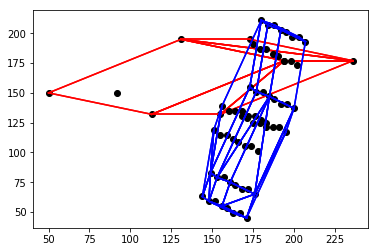

In [20]:
h[0].plot_dual_sub(color='red',name='b')

g[0].plot_dual_sub(color='blue',name='b')

# Полигоны Ньютона и subdivision для каждого из полиномов разницы по второй координате

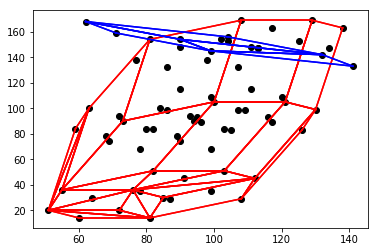

In [21]:
h[1].plot_dual_sub(color='red',name='b')

g[1].plot_dual_sub(color='blue',name='b')

# Составляем полином из статьи

In [22]:
R = h[0].minimize()*g[1].minimize() + h[1].minimize()*g[0].minimize()

In [23]:
R.minimize()

17.034575253725052⨀a^338⨀b^300 ⨁ 20.941018015146255⨀a^288⨀b^110 ⨁ 8.243710279464722⨀a^377⨀b^310 ⨁ 18.913968205451965⨀a^285⨀b^320 ⨁ 11.612618297338486⨀a^341⨀b^360 ⨁ 14.243696361780167⨀a^326⨀b^370 ⨁ 13.4920112490654⨀a^288⨀b^380 ⨁ 14.336047619581223⨀a^309⨀b^380 ⨁ 16.28667876124382⨀a^283⨀b^90 ⨁ 21.710610926151276⨀a^216⨀b^111 ⨁ 22.5546472966671⨀a^237⨀b^111 ⨁ 21.309304296970367⨀a^250⨀b^241 ⨁ 11.950369834899902⨀a^265⨀b^361 ⨁ 17.900308042764664⨀a^232⨀b^91 ⨁ 19.537897169589996⨀a^284⨀b^312 ⨁ 23.60465380549431⨀a^321⨀b^242 ⨁ 25.391695499420166⨀a^285⨀b^252 ⨁ 26.23573186993599⨀a^306⨀b^252 ⨁ 16.0327610373497⨀a^300⨀b^372 ⨁ 16.876797407865524⨀a^321⨀b^372 ⨁ 17.658504217863083⨀a^337⨀b^292 ⨁ 15.446389734745026⨀a^200⨀b^103 ⨁ -9.849054127931595⨀a^193⨀b^363 ⨁ 7.63677978515625⨀a^223⨀b^63 ⨁ 10.79205048084259⨀a^195⨀b^83 ⨁ 21.406013280153275⨀a^306⨀b^164 ⨁ 12.563207358121872⨀a^279⨀b^74 ⨁ 17.217546612024307⨀a^284⨀b^94 ⨁ 16.31787258386612⨀a^258⨀b^305 ⨁ 20.224315345287323⨀a^208⨀b^115 ⨁ 20.25485008955002⨀a^246⨀b^245 

# Полигоны Ньютона и subdivision для нового полинома и двух его слагаемых

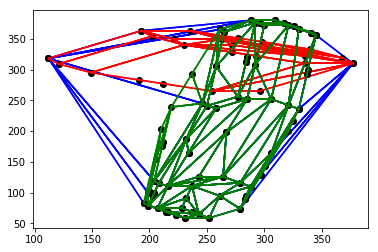

In [24]:
R.minimize().plot_dual_sub(color='blue',name='b')
(h[0]*g[1]).minimize().plot_dual_sub(color='red',name='b')
(h[1]*g[0]).minimize().plot_dual_sub(color='green',name='b')

# Рисуем реальную decision boundary исходной нейронки

In [28]:
def predict(x):
    x = torch.from_numpy(x).type(torch.FloatTensor)
    ans = model.forward(x)
    return ans.argmax(1).float().numpy()

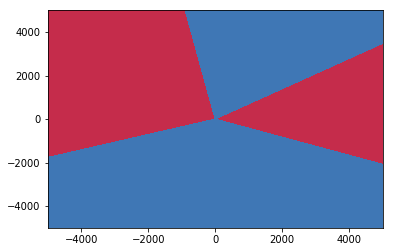

In [29]:
plot_decision_boundary(lambda x : predict(x))

# Видно, что decision boundary перпендикулярны тем границам полигона Нюьтона, которые не покрыты полигонами слагаемых.